In [1]:
import matplotlib
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from yellowbrick.regressor import residuals_plot

from src.common.validation.training import estimate_multiple_models, estimate_model
from src.tools.predictors import plot_prediction
from src.tools.predictors import plot_timeseries

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
%load_ext autoreload
%autoreload 2

#### Loading data

In [4]:
data = pd.read_csv('data2.csv', index_col=0)

#### Preprocessing

In [5]:
from sklearn.pipeline import Pipeline
from notebooks.Dzim.web_mining.bert_processor import DataCleaner, Vectorizer, TextCleaner
from notebooks.Dzim.web_mining.bert_processor import tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dzmit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dzmit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dzmit\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dzmit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
tc = TextCleaner()

In [7]:
tc.transform(data[:100])

,tweet
0,username woman complain clean house man always...
1,username boy dat cold tyga dwn bad cuffin dat ...
2,username dawg username ever fuck bitch start c...
3,username username look like tranny
4,username shit hear might true might faker bitc...
...,...
96,username go back school suck dick hoe attend
97,username way fuck yo bitch link year old
98,username username come never bring food dont c...
99,username richnow show hella tinder hoe im frie...


In [8]:
vec = Vectorizer(tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
import time

def estimate_time(f):
    def _estimate_time():
        start = time.time()
        f()
        end = time.time()
        print(end - start)

    return _estimate_time

In [10]:
@estimate_time
def test_processing():
    processed_data = tc.transform(data[:1000])

In [11]:
processed_data = tc.transform(data[:1000])

In [12]:
@estimate_time
def test_vectorizing():
    vec.transform(processed_data)

In [13]:
# test_processing()

In [14]:
# test_vectorizing()

In [15]:
nlp = Pipeline([
    ("preprocessing", TextCleaner()),
    ("vectorizing", Vectorizer(tokenizer))
])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
import pandas as pd

data_sample = pd.DataFrame({
    'tweet': [
        'Sasha goes to Mannheim University',
        'Danylo will create a great application',
        'Danylo will not create a great application',
        'Dasha didnt fulfill her task'
    ],
    'class': [1, 1, 0, 0]
})


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dzmit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
from notebooks.Dzim.web_mining.feature_generation import FeatureGenerator

fg = FeatureGenerator()

In [37]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("nlp", nlp, ['tweet']),
        ("feat_gen", FeatureGenerator(), ['tweet']),
    ],
    remainder='drop'
)

In [38]:
fg.transform(data_sample)

,rt_flag,contains_profanity_words_flag,sentiment_score_of_row,number_of_words_in_row,number_of_commas,number_of_excl_points,number_of_question_marks,number_of_full_stops
0,0,0,0.0000,5,0,0,0,0
1,0,0,0.7351,6,0,0,0,0
2,0,0,-0.6259,7,0,0,0,0
3,0,0,-0.3412,5,0,0,0,0


In [ ]:
processed_data = preprocessor.fit_transform(data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Features

In [41]:
features_to_exclude = ['count', 'offensive_language', 'neither']

In [42]:
features_to_exclude

['count', 'offensive_language', 'neither']

In [43]:
target_features = ['class']

target = "hate_speech"

In [44]:
features = [col for col in data.columns if col not in target_features + features_to_exclude]

In [45]:
nominal_features = []

In [46]:
data[features].head()

,hate_speech,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#### Models

In [47]:
from sklearn.dummy import DummyClassifier

dummy_mean = make_pipeline(
    DummyClassifier(strategy='most_frequent'),
)
dummy_median = make_pipeline(
    DummyClassifier(strategy='stratified'),
)

In [50]:
from sklearn.linear_model import LogisticRegression

lr = make_pipeline(
    # SimpleImputer(strategy='median', fill_value=0),
    LogisticRegression(),
)

In [51]:
from catboost import CatBoostClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier

ctb = make_pipeline(
    CatBoostClassifier()
)
xgb = make_pipeline(
    XGBClassifier()
)
lgbm = make_pipeline(
    LGBMClassifier()
)
rfc = make_pipeline(
    # SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(),
)

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_data, data[target], test_size=0.2, stratify=data[target])
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

C:\Users\dzmit\AppData\Local\Temp\ipykernel_31496\958497864.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, y_train, X_test, y_test = X.iloc[:size], data['hate_speech'][:size], X.iloc[size: size + test_size], data['hate_speech'][size: size + test_size]


In [152]:
# pipeline[:2].transform(X_train[:1000])

In [154]:
model = lr

In [155]:
model.fit(X_train, y_train)

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [156]:
prediction = model.predict(X_test)

In [157]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(classification_report(prediction, y_test))
    print(confusion_matrix(prediction, y_test))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       411
           1       0.18      0.19      0.19        73
           2       0.04      0.14      0.06        14
           3       0.08      0.50      0.14         2
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.66       500
   macro avg       0.20      0.27      0.20       500
weighted avg       0.74      0.66      0.70       500

[[313  62  28   5   2   1]
 [ 40  14  17   2   0   0]
 [  6   2   2   4   0   0]
 [  0   0   1   1   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


In [60]:
pipelines = [
    # ("Dummy_mean", dummy_mean),
    # ("Dummy_median", dummy_median),
    # ("LinReg", lr),
    # ("XGB", xgb),
    # ("LGBM", lgbm),
    # ("RFC", rfc),
    # ("CatBoost", ctb),
]

#### Data split

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_data, data[target][:4], test_size=0.2, stratify=data[target][:4])

C:\Users\dzmit\AppData\Local\Temp\ipykernel_16256\2766532410.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, X_test, y_train, y_test = train_test_split(processed_data, data[target][:4], test_size=0.2, stratify=data[target][:4])


In [54]:
pd.Series.value_counts(pd.Series(y_test))

0    1
Name: hate_speech, dtype: int64

In [55]:
X_train.shape, X_test.shape

((3, 24584), (1, 24584))

In [57]:
# lgbm.fit(X_train, y_train)

In [58]:
lr.fit(X_train, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [75]:
dummy_median.fit(X_train, y_train)
dummy_mean.fit(X_train, y_train)

Pipeline(steps=[('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

In [79]:
model = lr

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(cm)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.36      0.46      0.41      1643

    accuracy                           1.00   1272524
   macro avg       0.68      0.73      0.70   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
[[1269557    1324]
 [    884     759]]


In [81]:
y_pred = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

print(classification_report(y_train, y_pred))

print("Confusion matrix:")
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       0.36      0.43      0.39      6570

    accuracy                           1.00   5090096
   macro avg       0.68      0.71      0.69   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix:
[[5078427    5099]
 [   3743    2827]]


In [68]:
#### training
model_names, model_pipelines = zip(*pipelines)
metrics, weights = estimate_multiple_models(
    model_pipelines,
    lambda pipeline, _: estimate_model(
        pipeline,
        (X_train, X_test, y_train, y_test),
    ),
    model_names
)

Learning rate set to 0.097383
0:	learn: 11.2522444	total: 29.4ms	remaining: 29.4s
1:	learn: 10.6722595	total: 56.8ms	remaining: 28.4s
2:	learn: 10.1733319	total: 83.1ms	remaining: 27.6s
3:	learn: 9.7366798	total: 109ms	remaining: 27s
4:	learn: 9.3655319	total: 134ms	remaining: 26.6s
5:	learn: 9.0283489	total: 159ms	remaining: 26.3s
6:	learn: 8.7298888	total: 184ms	remaining: 26s
7:	learn: 8.4818987	total: 209ms	remaining: 25.9s
8:	learn: 8.2743569	total: 234ms	remaining: 25.7s
9:	learn: 8.0903608	total: 264ms	remaining: 26.1s
10:	learn: 7.9250592	total: 290ms	remaining: 26s
11:	learn: 7.7800737	total: 315ms	remaining: 25.9s
12:	learn: 7.6622571	total: 338ms	remaining: 25.7s
13:	learn: 7.5634860	total: 365ms	remaining: 25.7s
14:	learn: 7.4667530	total: 388ms	remaining: 25.5s
15:	learn: 7.3863565	total: 411ms	remaining: 25.3s
16:	learn: 7.3040626	total: 435ms	remaining: 25.1s
17:	learn: 7.2371668	total: 462ms	remaining: 25.2s
18:	learn: 7.1894214	total: 485ms	remaining: 25.1s
19:	learn: 

In [69]:
metrics

set                  train                                           \
metric                mape     rmspe      mse    rmse    mae     r2   
model                                                                 
Dummy_mean    4.978245e+15  2807.393  141.852  11.910  9.509  0.000   
Dummy_median  3.633914e+15  2926.944  153.774  12.401  9.186 -0.084   
LinReg        1.451253e+15  2342.821   51.887   7.203  5.157  0.634   
XGB           6.767182e+14  2156.503   26.125   5.111  3.513  0.816   
LGBM          7.147536e+14  2217.374   33.192   5.761  3.915  0.766   
RFC           2.038291e+14  1879.136    3.173   1.781  1.182  0.978   
CatBoost      6.792486e+14  2161.279   26.495   5.147  3.532  0.813   

set                                      test                             \
metric       adjusted_r2  rmsle          mape     rmspe      mse    rmse   
model                                                                      
Dummy_mean        -0.000  1.163  4.493511e+15  3624.162  234.871  15.325   
Dummy_median      -0.084  1.083  3.280078e+15  3777.634  268.146  16.375   
LinReg             0.634  0.684  1.365776e+15  3010.361   88.589   9.412   
XGB                0.816  0.479  7.948953e+14  2939.370   75.452   8.686   
LGBM               0.766  0.509  6.970253e+14  2938.786   73.700   8.585   
RFC                0.978  0.220  6.180259e+14  2905.783   69.415   8.332   
CatBoost           0.813  0.480  7.124043e+14  2938.209   73.773   8.589   

set                                             
metric           mae     r2 adjusted_r2  rmsle  
model                                           
Dummy_mean    11.484 -0.042      -0.043  1.147  
Dummy_median  11.551 -0.190      -0.190  1.111  
LinReg         6.379  0.607       0.607  0.682  
XGB            5.589  0.665       0.665  0.556  
LGBM           5.453  0.673       0.673  0.532  
RFC            5.298  0.692       0.692  0.521  
CatBoost       5.468  0.673       0.673  0.534

In [70]:
print(weights)

                                                 weight
model    feature                                       
LinReg   onehotencoder__hour_5                    7.338
         onehotencoder__holiday_name_Labour Day   4.982
         onehotencoder__hour_12                   3.989
         onehotencoder__hour_10                   3.979
         onehotencoder__hour_11                   3.976
...                                                 ...
CatBoost meanencoder__conditions                  0.002
         remainder__year                          0.002
         remainder__snow                          0.002
         remainder__precip                        0.001
         meanencoder__is_holiday                  0.000

[277 rows x 1 columns]


In [71]:
for name, _ in pipelines:
    try:
        print("#" * 80)
        print(name)
        print(weights.loc[name])
    except KeyError:
        print('Not Supported')

################################################################################
Dummy_mean
Not Supported
################################################################################
Dummy_median
Not Supported
################################################################################
LinReg
                                            weight
feature                                           
onehotencoder__hour_5                        7.338
onehotencoder__holiday_name_Labour Day       4.982
onehotencoder__hour_12                       3.989
onehotencoder__hour_10                       3.979
onehotencoder__hour_11                       3.976
...                                            ...
onehotencoder__conditions_Snow, Rain        -3.959
onehotencoder__holiday_name_Christmas Day   -5.313
onehotencoder__hour_2                      -10.164
onehotencoder__hour_22                     -10.478
<BIAS>                                    -343.278

[142 rows x 1 columns]
###########

In [82]:
from src.common.prediction_model.persistence import FsModelPersistence
from src.common.validation.metrics import aggregate_metrics
from src.common.prediction_model.prediction_model import ModelContainer, ModelMetadata

container = ModelContainer.create(
    pipeline_name='bus_occupancy_prediction',
    pipeline=lgbm,
    feature_names=features,
    metadata=ModelMetadata(
        model_name=str(lgbm.__class__.__name__),
        **aggregate_metrics(metrics)['test'].loc["LGBM"]
    )
)


In [83]:
# %%
persistor = FsModelPersistence()
name = persistor.save(container)

In [84]:
name

'bus_occupancy_prediction_Pipeline_2023-04-17.bin.gz'

In [119]:
from sklearn.metrics import classification_report, confusion_matrix

In [120]:
import numpy as np
bin_ranges = np.array([25, 50, 100]) # define bin ranges

pred = lgbm.predict(X_test) # get predictions from your regressor

pred_binned = np.digitize(pred, bin_ranges) # assign each prediction to a bin
y_binned = np.digitize(y_test, bin_ranges) # assign each y_test to a bin


In [134]:
pred_val_counts = pd.DataFrame(pred_binned).value_counts()
pred_val_counts.index=['0-25', '26-50', '51-100']

pred_val_counts

0-25      65566
26-50     14592
51-100      114
dtype: int64

In [135]:
y_val_counts = pd.DataFrame(y_binned).value_counts()
y_val_counts.index=['0-25', '26-50', '51-100', '100<']

y_val_counts

0-25      60840
26-50     16597
51-100     2831
100<          4
dtype: int64

In [129]:
print(classification_report(
    y_binned,
    pred_binned,
    target_names=['0-25', '26-50', '51-100', '100<'],
))
print(confusion_matrix(y_binned, pred_binned))

              precision    recall  f1-score   support

        0-25       0.88      0.95      0.91     60840
       26-50       0.62      0.54      0.58     16597
      51-100       0.75      0.03      0.06      2831
        100<       0.00      0.00      0.00         4

    accuracy                           0.83     80272
   macro avg       0.56      0.38      0.39     80272
weighted avg       0.82      0.83      0.81     80272

[[57665  3173     2     0]
 [ 7573  8997    27     0]
 [  328  2418    85     0]
 [    0     4     0     0]]


C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Report

In [74]:

# Create the visualizer, fit, score, and show it
for name, pipeline in pipelines:
    plt.figure()
    viz = residuals_plot(pipeline, X_train, y_train, X_test, y_test, is_fitted=True, test_alpha=0.3, show=False)
    plt.savefig(f'residual_{name}.png')

In [47]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'

<Figure size 640x480 with 0 Axes>

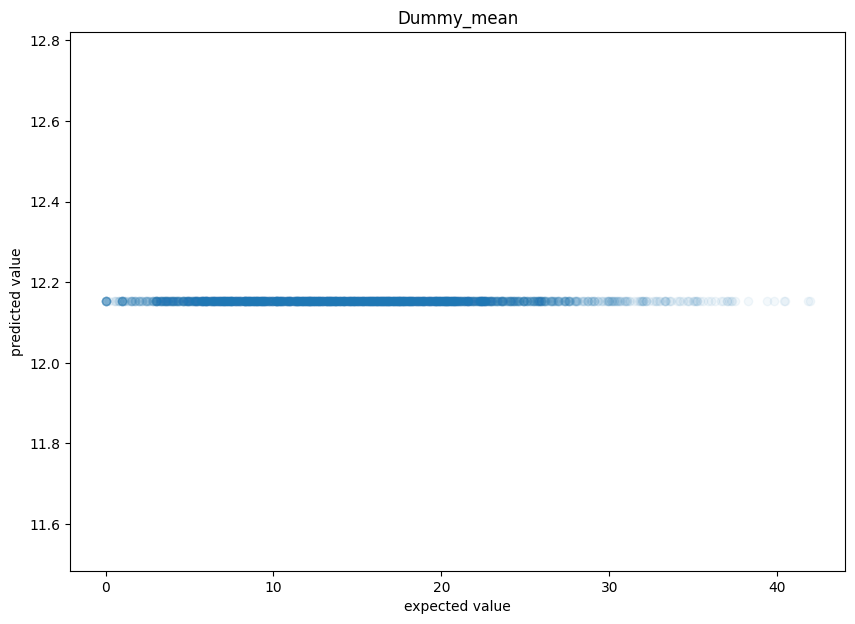

<Figure size 640x480 with 0 Axes>

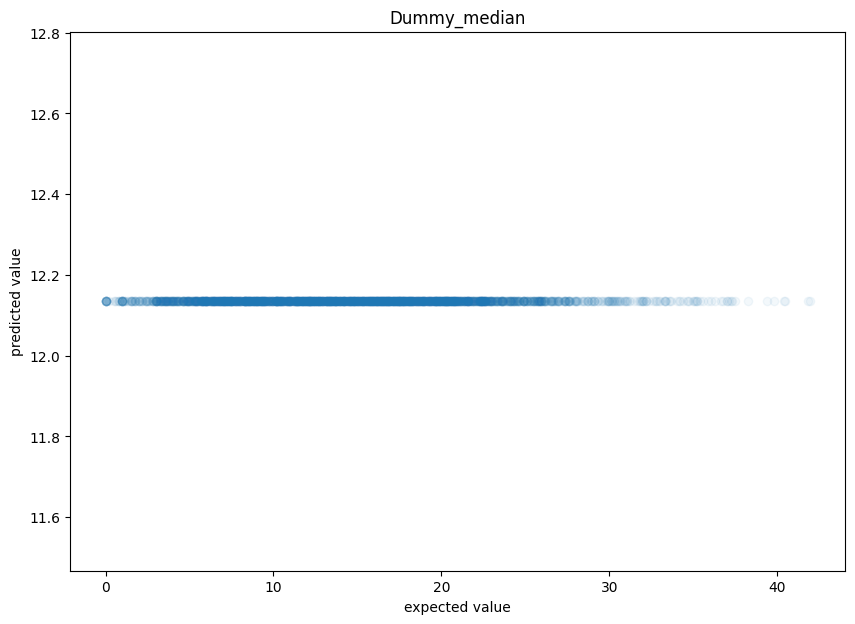

<Figure size 640x480 with 0 Axes>

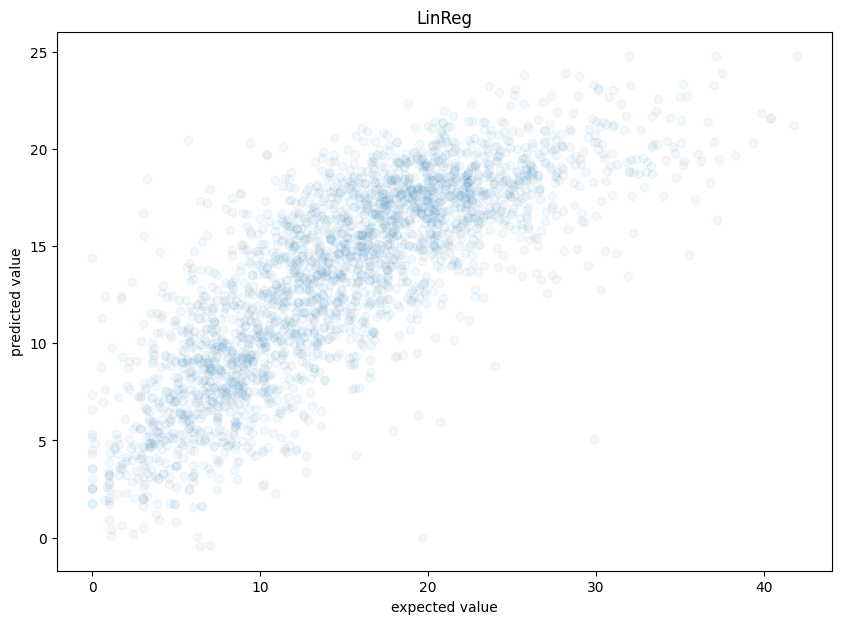

<Figure size 640x480 with 0 Axes>

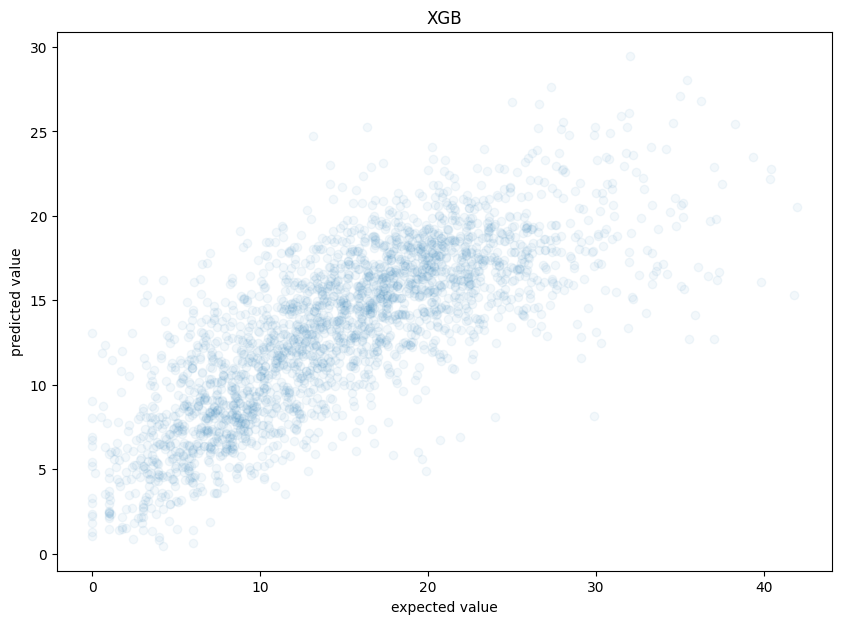

<Figure size 640x480 with 0 Axes>

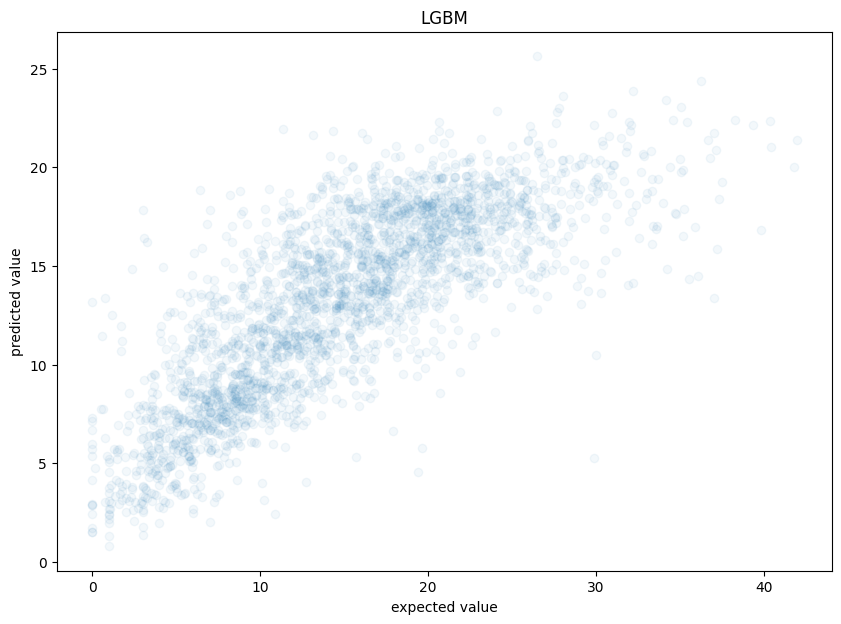

<Figure size 640x480 with 0 Axes>

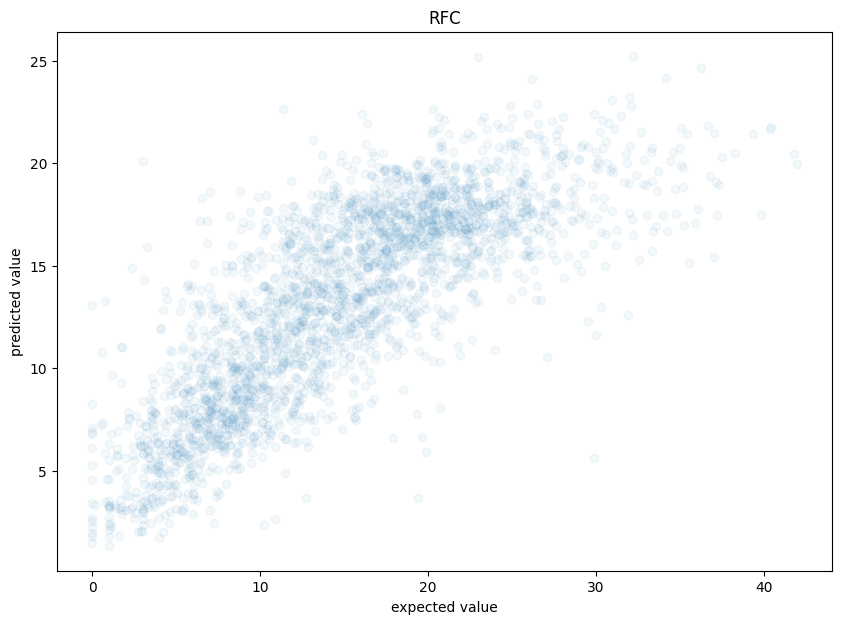

<Figure size 640x480 with 0 Axes>

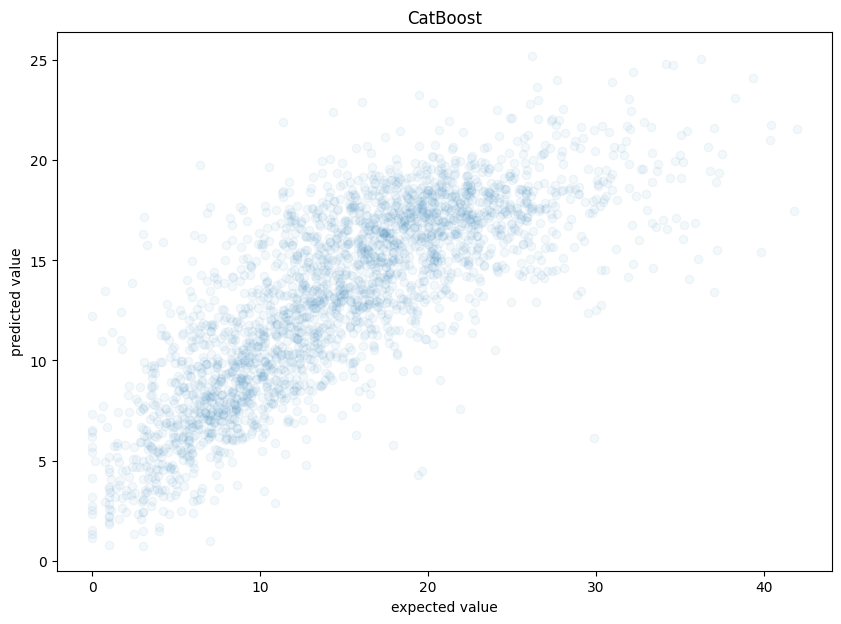

<Figure size 640x480 with 0 Axes>

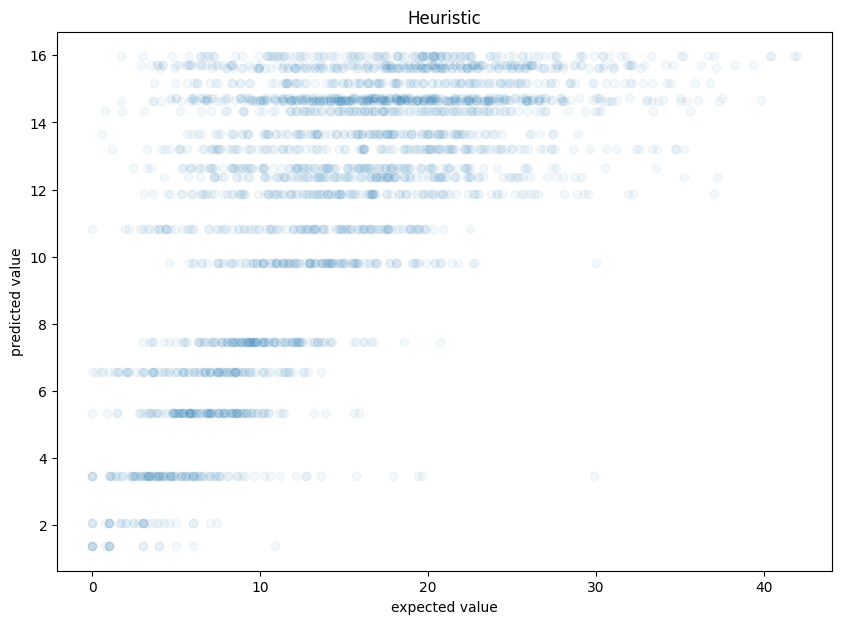

<Figure size 640x480 with 0 Axes>

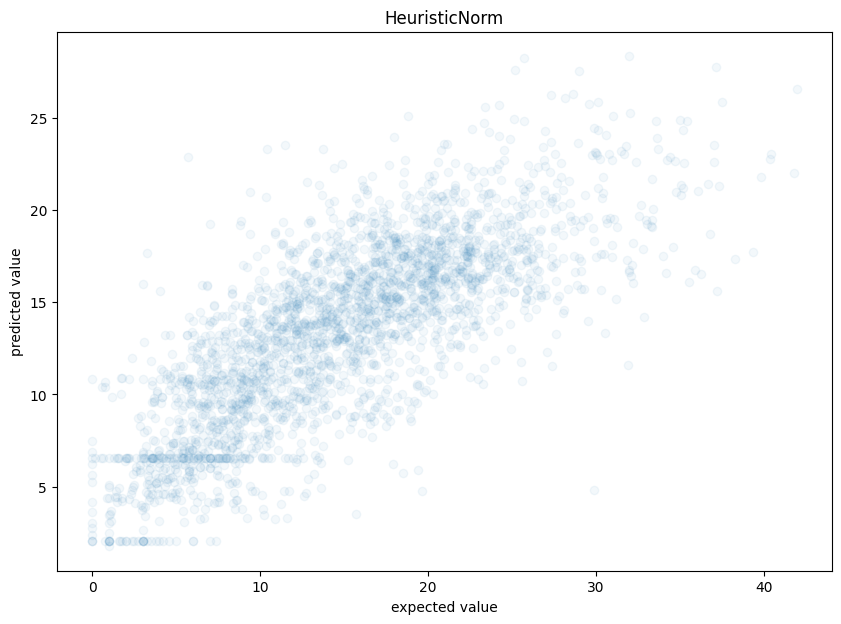

In [48]:
for name, pipeline in pipelines:
    # plt.figure()
    plot_prediction(
        y_test,
        pipeline.predict(X_test),
        name,
        False,
    )
    plt.savefig("prediction_" + name + '.png')

In [65]:
for name, pipeline in pipelines:
    plt.figure()
    plot_timeseries(
        y_test,
        pipeline.predict(X_test),
        name,
        False,
    )
    plt.savefig("time_series_" + name)